In [ ]:
import sys
import scripts.processing as proc
import scripts.plot_utils as plot
#from scripts.biomass_export import *
from omegaconf import OmegaConf

import joblib
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
from matplotlib import colors
from matplotlib.lines import Line2D
from cartopy.feature import OCEAN, RIVERS
from cmap import Colormap
import os

from cartopy.feature import OCEAN, RIVERS
import matplotlib.patheffects as pe
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

%load_ext autoreload 
%autoreload 2

cfg = OmegaConf.load('configs/glob_config.yaml')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
os.makedirs('images', exist_ok=True)

# Clustering

In [4]:
def plot_clustered_space(train_data, labels, pipeline, axs, fontsize = 13):

    cols = map_colors_to_labels(train_data, labels)

    cmap = colors.ListedColormap(cols)

    # CENTER B PLOT
    axs["B"].set_xlabel("$\Delta$Chl [mg m$^{-3}$]", fontsize = fontsize)
    axs["B"].set_ylabel("$\Delta$SST [°C]", fontsize = fontsize)
    
    axs["B"].plot(train_data["chl"], train_data["sst"], ".", 
                  markersize = 3, alpha = .7, zorder = -2,
                 color = "dimgray")
    
    
    yabs_max = abs(max(axs["B"].get_ylim(), key=abs))
    xabs_max = abs(max(axs["B"].get_xlim(), key=abs))
    
    axs["B"].set_ylim(ymin=-yabs_max, ymax=yabs_max)
    axs["B"].set_xlim(xmin=-xabs_max, xmax=xabs_max)
    
    axs["B"].hlines(0, xmin = -xabs_max, xmax = xabs_max, color = "dimgray", linestyle = "dashed", linewidth = .5)
    axs["B"].vlines(0, ymin = -yabs_max, ymax = yabs_max, color = "dimgray", linestyle = "dashed", linewidth = .5)
    h = 0.02  # step size of the mesh
    
    xx, yy = np.meshgrid(np.arange(-xabs_max, xabs_max, h), np.arange(-yabs_max, yabs_max, h))
    Z = pipeline.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    axs["B"].contour(xx, yy, Z, alpha=0.5, colors = "black", linewidths = .5)
    axs["B"].imshow(
            Z,
            interpolation="nearest",
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=cmap,
            aspect="auto",
            origin="lower",
            zorder = -1, alpha = 0.5
        )
    
    centroids = pipeline["km"].cluster_centers_

    for c, i in cols.items():
        if c == 'green':
            axs["B"].text(20, -4, str(i), ha = "center", va = "center", size = 15, 
                          color = c, path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        elif c == 'royalblue':
            axs["B"].text(-5, -6, str(i), ha = "center", va = "center", size = 15, 
                          color = c, path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        elif c == 'salmon':
            axs["B"].text(-20, 4, str(i), ha = "center", va = "center", size = 15, 
                          color = c, path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        elif c == 'yellow':
            axs["B"].text(0, 0, str(i), ha = "center", va = "center", size = 15, 
                          color = c, path_effects=[pe.withStroke(linewidth=1, foreground="black")])

    
    chl_x = np.linspace(train_data["chl"].min(), train_data["chl"].max(), 50)
    sst_x = np.linspace(train_data["sst"].min(), train_data["sst"].max(), 50)

    
    # UPPER CHL KERNEL PLOT
    axs["A"].set_xticks([])
    axs["A"].set_xlim(xmin=-xabs_max, xmax=xabs_max)
    axs["A"].hist(train_data["chl"], alpha = .5, density = True, bins = 20, color = 'grey')
    axs["A"].vlines(0, ymin = 0, ymax = max(axs["A"].get_ylim(), key=abs), 
                    color = "dimgray", linestyle = "dashed", linewidth = .5)
    
    
    # RIGHT SST KERNEL PLOT
    axs["C"].set_yticks([])
    axs["C"].set_ylim(ymin=-yabs_max, ymax=yabs_max)
    #axs["C"].plot(sst_kde(sst_x), sst_x, color = "black")
    axs["C"].hist(train_data["sst"], alpha = .5, density = True, bins = 20, orientation = "horizontal", color = 'grey')
    axs["C"].hlines(0, xmin = 0, xmax = max(axs["C"].get_xlim(), key=abs), 
                    color = "dimgray", linestyle = "dashed", linewidth = .5)
    
    
    # UPPER RIGHT POPULATION PLOT
    axs["D"].set_ylim([0,50])
    axs["D"].set_yticks([0, 25, 50])
    counts = pd.DataFrame({"labels" : labels}).value_counts().sort_index()
    perc_counts = counts / len(labels) * 100
    
    axs["D"].bar(range(len(centroids)), perc_counts, color = cols, edgecolor = "black", alpha = 0.7)
    axs["D"].set_xticks(range(0, len(perc_counts)))
    axs["D"].xaxis.set_ticks_position('none') 
    axs["D"].tick_params(axis='x', which='major', pad=-2)
    axs["D"].yaxis.tick_right()
    axs["D"].set_yticklabels(["0%", "25%", "50%"])

    return axs

from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_fils(ax, date, folder_path, group_idx, norm_chl, norm_sst, bigbox):
    
    region = proc.read_region_input_files(os.path.join(folder_path, 'regions.input'))

    bathymetry = xr.open_dataarray('/data01/benassi/export-biomass/data/processed/bathymetry.nc')

    boxes = [box for boxes in region.values() for box in boxes]
    groups = proc.obtain_boxes_grouping(region)[group_idx]


    chl = proc.crop_region('/data01/benassi/export-biomass/data/processed/chl_2003-2023.zarr', box = bigbox)
    sst = proc.crop_region('/data01/benassi/export-biomass/data/processed/sst_2003-2023.zarr', box = bigbox)

    bathy_mask = crop_square(bathymetry, box = bigbox, engine = 'netcdf4') 
    chl, sst = chl.where(bathy_mask < cfg.ref_depth), sst.where(bathy_mask < cfg.ref_depth)


    c_chl = ax[0].contourf(chl.longitude, chl.latitude, chl.sel(time = date), 
                           cmap = Colormap('chrisluts:I_Forest').to_mpl(), 
                           norm = norm_chl, 
                           extend = 'max', 
                           levels = np.linspace(0, norm_chl.vmax, 50))
    
    c_sst = ax[1].contourf(sst.longitude, sst.latitude, sst.sel(time = date), 
                           cmap = Colormap('cmocean:balance').to_mpl(), 
                           norm = norm_sst, 
                           extend = 'both', 
                           vmin = norm_sst.vmin,
                           vmax = norm_sst.vmax,
                           levels = np.linspace(norm_sst.vmin, norm_sst.vmax, 50))

    for idx in groups:
        if 'pacific' in folder_path:
            region_name = 'pacific'
        elif 'atlantic' in folder_path:
            region_name = 'atlantic'
        else:
            raise ValueError('No region found')
        mask = xr.open_dataarray(os.path.join(folder_path, f'outputs/streamers_masks/box_{idx}.nc')).sel(time = date).astype(int)
        warm_mask = xr.open_dataarray(f'{region_name}/warm_fils/box_{idx}.nc').sel(time = date).astype(int)
        cold_mask = mask - warm_mask

        # Combine masks into a single mask: 0 = background, 1 = red, 2 = blue
        combined_mask = warm_mask * 1 + cold_mask * 2

        # Define a custom colormap
        cmap = ListedColormap(['white', Color('red'), Color('blue')])
        norm = BoundaryNorm([0, 1, 2, 3], cmap.N)  # Define boundaries for color mapping
        for a in ax[:2]:
            a.contour(chl.longitude, chl.latitude, bathy_mask, [cfg.ref_depth], colors = "red", linestyles = "solid", linewidths = .6)
            a.contour(mask.longitude, mask.latitude, mask, levels = [0.1, 1], colors = 'black')
            a.set_xlim([bigbox[0], bigbox[1]])
            a.set_ylim([bigbox[2], bigbox[3]])

        
        mesh = ax[2].pcolormesh(
            combined_mask.longitude, combined_mask.latitude, combined_mask,
            cmap=cmap, norm = norm
        )
        ax[2].set_xlim([bigbox[0], bigbox[1]])
        ax[2].set_ylim([bigbox[2], bigbox[3]])


    cb_chl = plt.colorbar(c_chl, ax = ax[0], orientation = 'horizontal', shrink = .8)
    cb_chl.set_label(label = 'Chlorophyll concentration [mg m$^{-3}$]', fontsize = 12)
    cb_sst = plt.colorbar(c_sst, ax = ax[1], orientation = 'horizontal', shrink = .8)
    cb_sst.set_label(label = 'Sea surface temperature [°C]', fontsize = 12)
    
    cb_mesh = plt.colorbar(mesh, ax=ax[2], orientation = 'horizontal', shrink = .8, label='')

    cb_chl.ax.set_xticks(np.arange(0, 3.5, 0.5))
    cb_sst.ax.set_xticks(np.arange(10, 30, 5))
    cb_mesh.ax.set_xticks([1.5, 2.5], labels = ['$\Delta$SST $\geq$ 0', '$\Delta$SST < 0'], fontsize = 12)

    handles = [Line2D([0], [0], linestyle='solid', label = f'Reference depth = {cfg.ref_depth} m', color = 'red'),
            Line2D([0], [0], linestyle='solid', label = f'Streamers mask', color = 'black')]
    ax[0].legend(handles = handles, loc = 'lower left')#, ncol=2, prop = {'size' : 20})
    return ax

def map_colors_to_labels(train_data, labels):
    
    colors_list = ["yellow", "red", "blue", "green"]

    
    cold_cluster = labels[np.argmin(train_data["sst"])]
    filament_cluster = labels[np.argmax(train_data["chl"])]
    warm_cluster = labels[np.argmax(train_data["sst"])]
    if filament_cluster == cold_cluster:
        filtered_train = train_data.iloc[labels != filament_cluster]
        filtered_labels = labels[labels!=filament_cluster]
        cold_cluster = filtered_labels[np.argmin(filtered_train["sst"])]
    
    # Identify the last remaining cluster
    all_clusters = set({0,1,2,3})
    remaining_cluster = list(all_clusters - {filament_cluster, cold_cluster, warm_cluster})[0]

    # Assign colors
    cluster_colors = {
        "green" : filament_cluster,
        "royalblue" : cold_cluster,
        "salmon" : warm_cluster,
        "yellow" : remaining_cluster
    }
    
    cluster_colors = {color: number for color, number in sorted(cluster_colors.items(), key=lambda item: item[1])}

    return cluster_colors

In [ ]:
fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(2, 3, wspace=0.07)

path = 'supplementary_data'

atl_regions = [c for c in proc.read_region_input_files('configs/atlantic_regions.input').keys()]
pac_regions = [c for c in proc.read_region_input_files('configs/pacific_regions.input').keys()]

regions = [pac_regions,
        atl_regions]

paths = ['pacific', 
         'atlantic']

titles = [["(a) California Current System", "(b) Central America", "(c) Humboldt Current System"],
          ["(d) Canary Current System", "(e) Central Africa", "(f) Benguela Current System"]]

for row in range(subfigs.shape[0]):
    for col in range(subfigs.shape[1]):

        train_data = pd.read_csv(f"{os.path.join('supplementary_data', 'train_data', paths[row])}{regions[row][col]}.csv", index_col = 0)
        labels = np.load(f"{os.path.join("supplementary_data", 'labels', paths[row])}{regions[row][col]}.npy")
        pipeline = joblib.load(f"{os.path.join("supplementary_data", 'models', paths[row])}{regions[row][col]}.joblib")
        axs = subfigs[row, col].subplot_mosaic("""AAAD
                            BBBC
                            BBBC
                            BBBC""")
        plot_clustered_space(train_data, labels, pipeline, axs)
        subfigs[row, col].suptitle(titles[row][col], fontsize = 15)

plt.savefig("images/clustered_spaces.jpg", bbox_inches = "tight")

FileNotFoundError: [Errno 2] No such file or directory: 'sensitivity_test_years/atlantic/10years/regions.input'

<Figure size 2000x1000 with 0 Axes>

In [ ]:
data_path = "/data01/benassi/export-biomass/data/processed/"

bathy_path = os.path.join(data_path, "bathymetry.nc")

ref_depth = cfg.ref_depth

def pacific_occupation(ax):
    ax.set_xlim(-135, -60)

    colors = ['#1b9e77', '#d95f02', '#7570b3']
    regions = proc.read_region_input_files('configs/pacific_regions.input')

    boxes = [box for boxes in regions.values() for box in boxes]

    for i, box in enumerate(boxes):
        i+=1

        x, y = plot.xy_rectangle(box)
        #ax.plot(x,y, color = "black", linewidth = .5)

        streamers_masks = xr.open_dataarray(f"supplementary_data/streamers_masks/pacific/streamers_masks/box_{i}.nc")
        counts = streamers_masks.sum(axis = 0)
        total_count = len(streamers_masks)

        lons, lats = slice(box[0], box[1]), slice(box[2], box[3])
        bathy = xr.open_dataarray(bathy_path).sel(longitude = lons, latitude = lats)

        if i in [1, 2, 3]:
            color = colors[0]
        elif i in [4, 5, 6, 7]:
            color = colors[1]
        else:
            color = colors[2]

        ax.plot(x,y, color = color, path_effects = [pe.withStroke(linewidth=3, foreground="black")])

        counts = counts.where(bathy <= ref_depth)

        c = ax.contourf(counts.longitude, counts.latitude, counts / total_count * 100, cmap = "binary", 
                        vmin = 0, vmax = 2.5, levels = np.arange(0, 2.75, 0.25), extend = "max")

        ax.contour(bathy.longitude, bathy.latitude, bathy, [ref_depth], 
                    colors = "red", linestyles = "solid", linewidths = .6)
        if i == 3 or i == 2:
            ax.text(np.mean(x), np.mean(y) - 7.5, f"{i}", color = color, 
                path_effects=[pe.withStroke(linewidth=1, foreground="black")], size = 12)
        elif i == 4:
            ax.text(np.mean(x), np.mean(y) + 7.5, f"{i}", color = color, 
                path_effects=[pe.withStroke(linewidth=1, foreground="black")], size = 12)       
        else:
            ax.text(np.mean(x) + 7.5, np.mean(y), f"{i}", color = color, 
                    path_effects=[pe.withStroke(linewidth=1, foreground="black")], size = 12)


    ax.set_title("(a) Eastern Pacific boundary", fontsize = 15)


    ax.legend(handles=[mpatches.Patch(color=colors[0], label = "California Current System"),
                    mpatches.Patch(color=colors[1], label = "Central America"),
                    mpatches.Patch(color=colors[2], label = "Humboldt Current System"),
                    Line2D([0], [0], color="red", label = f"Reference depth = {ref_depth} m")],
            loc = "lower left")


def atlantic_occupation(ax):

    ax.set_xlim(-35, 40)
    ax.set_ylim(-60, 60)
    ax.add_feature(RIVERS)

    colors = ['#e7298a', '#66a61e', '#e6ab02']
    
    regions = proc.read_region_input_files('configs/atlantic_regions.input')

    boxes = [box for boxes in regions.values() for box in boxes]

    for i, box in enumerate(boxes):

        i += 1

        
        x, y = plot.xy_rectangle(box)

        streamers_masks = xr.open_dataarray(f"supplementary_data/streamers_masks/atlantic/box_{i}.nc")
        counts = streamers_masks.sum(axis = 0)
        total_count = len(streamers_masks)

        lons, lats = slice(box[0], box[1]), slice(box[2], box[3])
        bathy = xr.open_dataarray(bathy_path).sel(longitude = lons, latitude = lats)
        
        if i in [1, 2, 3, 4]:
            color = colors[0]
        elif i in [5, 6, 7]:
            color = colors[1]
        else:
            color = colors[2]
        
        counts = counts.where(bathy <= ref_depth)

        
        c = ax.contourf(counts.longitude, counts.latitude, counts / total_count * 100, cmap = "binary", 
                        vmin = 0, vmax = 2.5, levels = np.arange(0,2.75,0.25), extend = "max")
        
        ax.plot(x,y, color = color, path_effects = [pe.withStroke(linewidth=3, foreground="black")])

        ax.contour(bathy.longitude, bathy.latitude, bathy, [ref_depth], 
                    colors = "red", linestyles = "solid", linewidths = .6)
        if i == 3:
            ax.text(np.mean(x) + 7.5, np.mean(y), f"{i}", color = color, 
                path_effects=[pe.withStroke(linewidth=1, foreground="black")], size = 12)
        elif i == 4:
            ax.text(np.mean(x), np.mean(y) - 7.5, f"{i}", color = color, 
                path_effects=[pe.withStroke(linewidth=1, foreground="black")], size = 12)
        elif i == 5:
            ax.text(np.mean(x), np.mean(y) + 7.5, f"{i}", color = color, 
                path_effects=[pe.withStroke(linewidth=1, foreground="black")], size = 12)
        else:
            ax.text(np.mean(x) + 7.5, np.mean(y), f"{i}", color = color, 
                    path_effects=[pe.withStroke(linewidth=1, foreground="black")], size = 12)

    ax.legend(handles=[mpatches.Patch(color=colors[0], label = "Canary Current System"),
                    mpatches.Patch(color=colors[1], label = "Central Africa"),
                    mpatches.Patch(color=colors[2], label = "Benguela"),
                    Line2D([0], [0], color="red", label = f"Reference depth = {ref_depth} m")],
            loc = "lower left")

    ax.set_title("(b) Eastern Atlantic boundary", fontsize = 15)

    return c

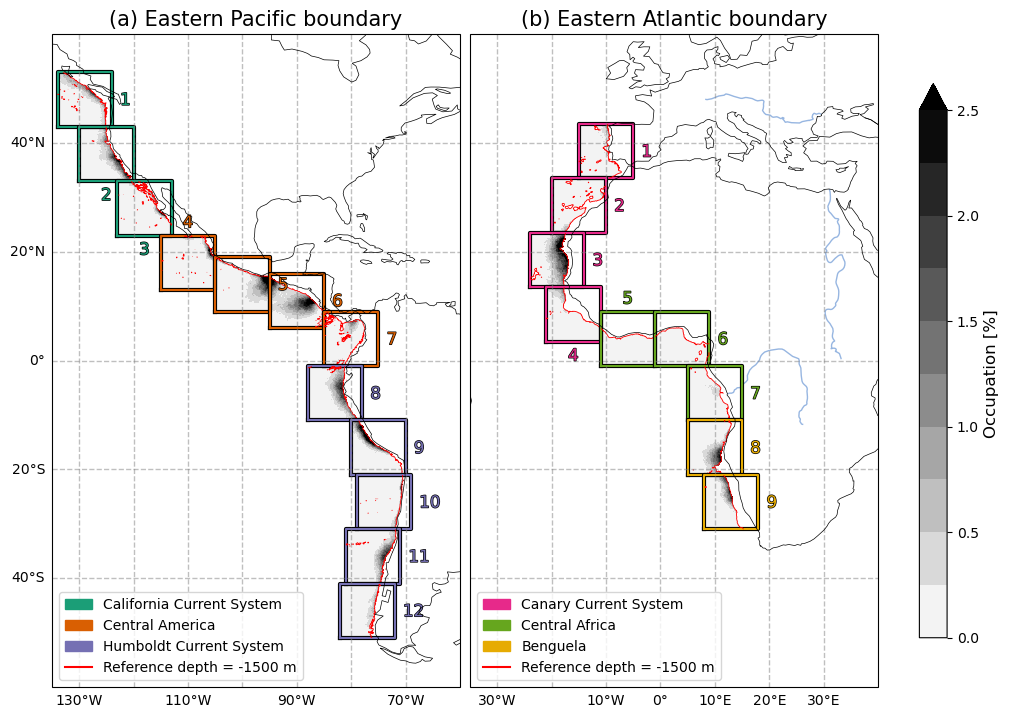

In [ ]:
fig, ax = plot.set_plot(ncols = 2, figsize = [10,8])


ax[0].sharey(ax[1])

pacific_occupation(ax[0])
c = atlantic_occupation(ax[1])

cb = plt.colorbar(c, ax = ax, shrink = 0.7)
cb.set_label("Occupation [%]", fontsize = 12)
cb.ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5])

plt.savefig("images/occupations.jpg", bbox_inches = "tight")

In [ ]:
data_path = "/data01/benassi/export-biomass/data/processed/"

bathy_path = os.path.join(data_path, "bathymetry.nc")

ref_depth = cfg.ref_depth

def plot_boxes(ax, box, color, idx, x_offset = 0, y_offset = 0):
    
    # Obtain coordinates of the box for plotting
    x, y = plot.xy_rectangle(box)

    # Plot the box
    ax.plot(x,y, color = color, path_effects = [pe.withStroke(linewidth=3, foreground="black")])

    ax.text(np.mean(x) + x_offset, np.mean(y) + y_offset, f'{idx}', color = color,
            path_effects=[pe.withStroke(linewidth=1, foreground="black")], size = 12)
    

    return ax


def plot_carbon_content_and_bathymetry(ax, path, idx, vmin, vmax):

    data = xr.open_dataarray(f"{path}/box_{idx}.nc").sum(dim = ['time']) * 50 / 21 * 1e3
    bathy = xr.open_dataarray(bathy_path).sel(longitude = data.longitude, latitude = data.latitude)
    data = data.where(bathy <= ref_depth)

    cm = Colormap('colorbrewer:blues').to_mpl()
    c = ax.contourf(data.longitude, data.latitude, data, cmap = cm, 
                    vmin = vmin, vmax = vmax, extend = "max", levels = np.arange(vmin, vmax, 5e-2))

    ax.contour(bathy.longitude, bathy.latitude, bathy, [ref_depth], 
                colors = "red", linestyles = "solid", linewidths = .6)

    return c, ax

def plot_occupation(ax, path, idx, vmin, vmax):

    data = xr.open_dataarray(f"{path}/box_{idx}.nc")
    counts = data.sum(dim = ['time'])
    total_count = len(data)
    bathy = xr.open_dataarray(bathy_path).sel(longitude = data.longitude, latitude = data.latitude)


    c = ax.contourf(counts.longitude, counts.latitude, counts / total_count * 100, cmap = "binary", 
                        vmin = vmin, vmax = vmax, levels = np.arange(vmin, vmax, 0.25), extend = "max")
    
    ax.contour(bathy.longitude, bathy.latitude, bathy, [ref_depth], 
                colors = "red", linestyles = "solid", linewidths = .6)

    return c, ax

def pacific_occupation(ax, vmin, vmax, path, compute_func):
    ax.set_xlim(-135, -60)

    colors = ['#1b9e77', '#d95f02', '#7570b3']

    colormap = {i : color for i, color in zip(range(len(colors)), colors)}

    regions = proc.read_region_input_files('sensitivity_test_years/pacific/10years/regions.input')
        
    groups = proc.obtain_boxes_grouping(regions)
    boxes = [box for boxes in regions.values() for box in boxes]

    text_offsets = {}
    for i in range(1, len(boxes) + 1):
        if i in [3, 4]:
            text_offsets[i] = [0, -7.5]
        elif i in [5, 6]:
            text_offsets[i] = [0, 7.5]
        else:
            text_offsets[i] = [7.5, 0]

    for i, group in enumerate(groups):
        
        for idx in group:

            box = boxes[idx - 1]

            ax = plot_boxes(ax, box, colormap[i], idx, text_offsets[idx][0], text_offsets[idx][1])
            _, ax = compute_func(ax,f'sensitivity_test_years/pacific/10years/outputs/{path}/', idx, vmin, vmax)

    ax.set_title("(a) Eastern Pacific boundary", fontsize = 15)

    handles = [mpatches.Patch(color=color, label = label) for color, label in zip(colormap.values(), regions.keys())] + \
            [Line2D([0], [0], color="red", label = f"Reference depth = {ref_depth} m")]

    ax.legend(handles=handles,
            loc = "lower left")


def atlantic_occupation(ax, vmin, vmax, path, compute_func):

    ax.set_xlim(-35, 40)
    ax.set_ylim(-60, 60)

    ax.add_feature(RIVERS)

    colors = ['#e7298a', '#66a61e', '#e6ab02']
    colormap = {i : color for i, color in zip(range(len(colors)), colors)}

    regions = proc.read_region_input_files('sensitivity_test_years/atlantic/10years/regions.input')
        
    groups = proc.obtain_boxes_grouping(regions)
    boxes = [box for boxes in regions.values() for box in boxes]

    text_offsets = {}
    for i in range(1, len(boxes) + 1):
        if i in [4]:
            text_offsets[i] = [0, -7.5]
        elif i in [5]:
            text_offsets[i] = [0, 7.5]
        else:
            text_offsets[i] = [7.5, 0]

    for i, group in enumerate(groups):
        
        for idx in group:

            box = boxes[idx - 1]

            ax = plot_boxes(ax, box, colormap[i], idx, text_offsets[idx][0], text_offsets[idx][1])
            c, ax = compute_func(ax, f'sensitivity_test_years/atlantic/10years/outputs/{path}/', idx, vmin, vmax)

    ax.set_title("(b) Eastern Atlantic boundary", fontsize = 15)

    handles = [mpatches.Patch(color=color, label = label) for color, label in zip(colormap.values(), regions.keys())] + \
            [Line2D([0], [0], color="red", label = f"Reference depth = {ref_depth} m")]

    ax.legend(handles=handles,
            loc = "lower right")

    return c

In [ ]:
def plot_export(export_dataset, colors_list, ax):
    
    ax.barh(y = np.arange(0, len(export_dataset))[::-1] + 1, width = export_dataset.export, 
            edgecolor = "black", color = colors, xerr = export_dataset.error)

    ax.set_ylabel("Region code", fontsize = 15)
    ax.set_yticks(np.arange(0,len(export_dataset))[::-1] + 1, labels = np.arange(0,len(colors_list)) + 1)


    return ax

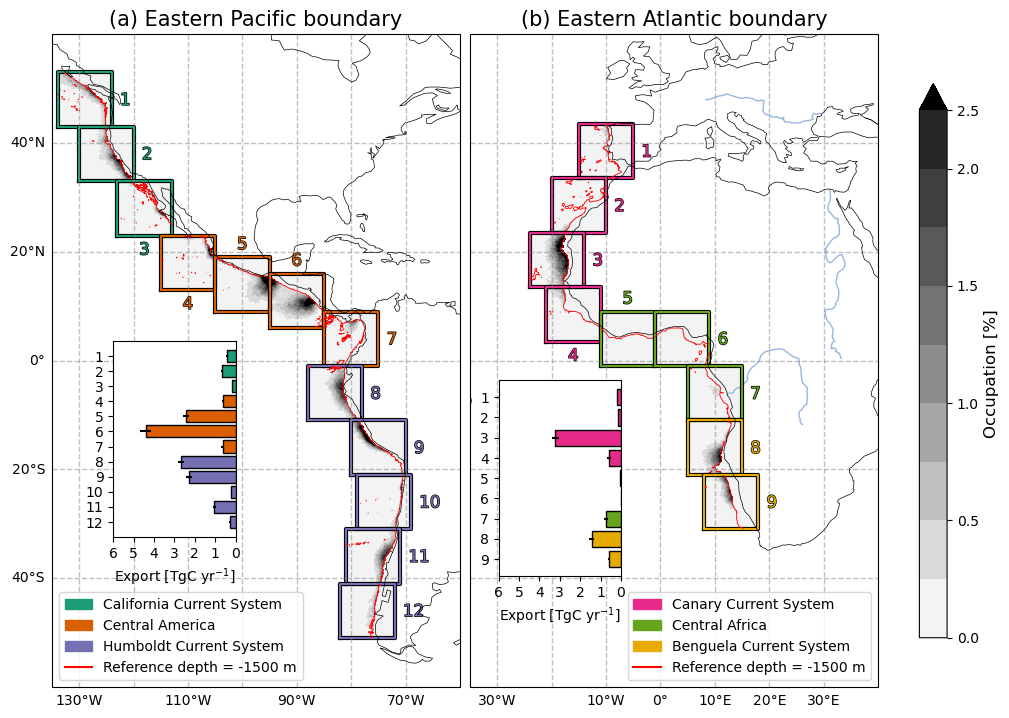

In [ ]:
fig, ax = plot.set_plot(ncols = 2, figsize = [10,8])

ax[1].set_ylim(-80, 80)
ax[0].sharey(ax[1])

vmin = 0
vmax = 2.5


pacific_occupation(ax[0], vmin, vmax, 'streamers_masks', plot_occupation)
c = atlantic_occupation(ax[1], vmin, vmax, 'streamers_masks', plot_occupation)

cb = plt.colorbar(c, ax = ax, shrink = 0.7)
cb.set_label("Occupation [%]", fontsize = 12)
cb.ax.set_yticks(np.arange(0,  3, 0.5))

ins_size = [0.15,0.23,0.3,0.3]
ins_pac = ax[0].inset_axes(ins_size)
export = pd.read_csv(pac_path, index_col = 0)


x_ticks = np.arange(0, 7, 1)
col_list = ['#1b9e77', '#d95f02', '#7570b3']
colors = [col_list[0]]*3 + [col_list[1]]*4 + [col_list[2]]*5
ins_pac = plot_export(export, colors, ins_pac)
ins_pac.set_xlim([0, 6])
ins_pac.set_ylabel('')
ins_pac.invert_xaxis()
ins_pac.set_xticks(x_ticks)
ins_pac.set_xlabel('Export [TgC yr$^{-1}$]')

ins_size = [0.07,0.17,0.3,0.3]
ins_atl = ax[1].inset_axes(ins_size)
export = pd.read_csv(atl_path, index_col = 0)
col_list = ['#e7298a', '#66a61e', '#e6ab02']
colors = [col_list[0]]*4 + [col_list[1]]*3 + [col_list[2]]*2
ins_atl = plot_export(export, colors, ins_atl)
ins_atl.set_xlim([0, 6])
ins_atl.set_ylabel('')
ins_atl.invert_xaxis()
ins_atl.set_xticks(x_ticks)
ins_atl.set_xlabel('Export [TgC yr$^{-1}$]')

plt.savefig('images/occupations_with_export.jpg', bbox_inches = 'tight')

In [ ]:
pac_path = "supplementary_data/filament_content/pacific/carbon_exports.csv"

pac_regions = proc.read_region_input_files(os.path.join('configs/pacific_regions.input'))
export = pd.read_csv(pac_path, index_col = 0)

for reg, groups in zip(pac_regions.keys(), proc.obtain_boxes_grouping(pac_regions)):

    print(reg, export.loc[groups].sum()[['export', 'error']].values)


California Current System [1.28308692 0.08835086]
Central America [8.11392678 0.51925737]
Humboldt Current System [6.50194066 0.41938034]


In [13]:
export.sum()[['export', 'error']]

export    15.898954
error      1.026989
dtype: float64

In [ ]:
atl_path = "supplementary_data/filament_content/atlantic/carbon_exports.csv"

atl_regions = proc.read_region_input_files(os.path.join('configs/atlantic_regions.input'))

export = pd.read_csv(atl_path, index_col = 0)

for reg, groups in zip(atl_regions.keys(), proc.obtain_boxes_grouping(atl_regions)):
    print(reg, export.loc[groups].sum()[['export', 'error']].values)


Canary Current System [4.11837336 0.29603572]
Central Africa [0.7891779  0.08895405]
Benguela Current System [2.02081875 0.15415178]


In [15]:
export = pd.read_csv(pac_path, index_col = 0)

print('Pacific : ', export.sum()[['export', 'error']])

Pacific :  export    15.898954
error      1.026989
dtype: float64


In [16]:
export = pd.read_csv(atl_path, index_col = 0)
print('Atlantic : ', export.sum()[['export', 'error']])

Atlantic :  export    6.928370
error     0.539142
dtype: float64


In [17]:
15.9 + 6.9

22.8

In [ ]:
def compute_pct_export(region):
    
    path = f"{region}/outputs"

    regions = proc.read_region_input_files(f'configs/{region}_regions.input')
    groups = proc.obtain_boxes_grouping(regions)

    shelf_content = pd.read_csv(os.path.join(path, 'shelf_content.csv'), index_col = 0)
    export = pd.read_csv(os.path.join(path, 'carbon_exports.csv'), index_col = 0)

    pct_dataframe = pd.DataFrame(index = regions.keys(), columns = ['export_pct', 'error'])
    for reg, group in zip(regions.keys(), groups):

        export_group = export.loc[group]
        shelf_group = shelf_content.loc[group]

        streamers_avails = np.sum([xr.open_dataarray(f'filament_content/{region}/box_{idx}.nc').count(dim = ['longitude', 'latitude']) for idx in group])
        
        shelf_avails = np.sum([xr.open_dataarray(f'shelf_content/{region}/box_{idx}.nc').count(dim = ['longitude', 'latitude']) for idx in group])

        export_pct = export_group['export'].sum() / shelf_group['content'].sum() * 100 * (shelf_avails / streamers_avails)
        pct_rel_error = export_group['error'].sum() / export_group['export'].sum() +  shelf_group['error'].sum() / shelf_group['content'].sum()

        pct_dataframe.loc[reg][['export_pct', 'error']] = [export_pct, pct_rel_error * export_pct]

    return pct_dataframe


In [ ]:
region = 'sensitivity_test_years/pacific/10years'
path = f"{region}/outputs"

regions = proc.read_region_input_files(os.path.join(f'{region}/regions.input'))
groups = proc.obtain_boxes_grouping(regions)

shelf_content = pd.read_csv(os.path.join(path, 'shelf_content.csv'), index_col = 0)
export = pd.read_csv(os.path.join(path, 'carbon_exports.csv'), index_col = 0)

bathymetry = xr.open_dataarray('../data/processed/bathymetry.nc')

streamers_avails = np.sum([xr.open_dataarray(os.path.join(path, f'content_timeseries/box_{idx}.nc')).count(dim = ['longitude', 'latitude']) for idx in range(1, len(export) + 1)])

shelf_avails = np.sum([xr.open_dataarray(os.path.join(path, f'shelf_content/box_{idx}.nc')).count(dim = ['longitude', 'latitude']) for idx in range(1, len(export) + 1)])

export_pct = export['export'].sum() / shelf_content['content'].sum() * 100 * (shelf_avails / streamers_avails)
pct_rel_error = export['error'].sum() / export['export'].sum() +  shelf_content['error'].sum() / shelf_content['content'].sum()

In [20]:
print(export_pct, pct_rel_error * export_pct)

21.152574986082758 2.000104741297818


In [ ]:
region = 'sensitivity_test_years/atlantic/10years'
path = f"{region}/outputs"


regions = proc.read_region_input_files(os.path.join(f'{region}/regions.input'))
groups = proc.obtain_boxes_grouping(regions)

shelf_content = pd.read_csv(os.path.join(path, 'shelf_content.csv'), index_col = 0)
export = pd.read_csv(os.path.join(path, 'carbon_exports.csv'), index_col = 0)

bathymetry = xr.open_dataarray('../data/processed/bathymetry.nc')

streamers_avails = np.sum([xr.open_dataarray(os.path.join(path, f'content_timeseries/box_{idx}.nc')).count(dim = ['longitude', 'latitude']) for idx in range(1, len(export) + 1)])

shelf_avails = np.sum([xr.open_dataarray(os.path.join(path, f'shelf_content/box_{idx}.nc')).count(dim = ['longitude', 'latitude']) for idx in range(1, len(export) + 1)])

export_pct = export['export'].sum() / shelf_content['content'].sum() * 100 * (shelf_avails / streamers_avails)
pct_rel_error = export['error'].sum() / export['export'].sum() +  shelf_content['error'].sum() / shelf_content['content'].sum()

In [22]:
print(export_pct, pct_rel_error * export_pct)

10.549000086148713 1.1515947782115572


In [ ]:
region = 'sensitivity_test_years/pacific/10years'
path = f"{region}/outputs"

regions = proc.read_region_input_files(os.path.join(f'{region}/regions.input'))
groups = proc.obtain_boxes_grouping(regions)

pac_shelf_content = pd.read_csv(os.path.join(path, 'shelf_content.csv'), index_col = 0)
pac_export = pd.read_csv(os.path.join(path, 'carbon_exports.csv'), index_col = 0)

bathymetry = xr.open_dataarray('../data/processed/bathymetry.nc')

pac_streamers_avails = np.sum([xr.open_dataarray(os.path.join(path, f'content_timeseries/box_{idx}.nc')).count(dim = ['longitude', 'latitude']) for idx in range(1, len(export) + 1)])
pac_shelf_avails = np.sum([xr.open_dataarray(os.path.join(path, f'shelf_content/box_{idx}.nc')).count(dim = ['longitude', 'latitude']) for idx in range(1, len(export) + 1)])

region = 'sensitivity_test_years/atlantic/10years'
path = f"{region}/outputs"

regions = proc.read_region_input_files(os.path.join(f'{region}/regions.input'))
groups = proc.obtain_boxes_grouping(regions)

atl_shelf_content = pd.read_csv(os.path.join(path, 'shelf_content.csv'), index_col = 0)
atl_export = pd.read_csv(os.path.join(path, 'carbon_exports.csv'), index_col = 0)

bathymetry = xr.open_dataarray('../data/processed/bathymetry.nc')

atl_streamers_avails = np.sum([xr.open_dataarray(os.path.join(path, f'content_timeseries/box_{idx}.nc')).count(dim = ['longitude', 'latitude']) for idx in range(1, len(export) + 1)])
atl_shelf_avails = np.sum([xr.open_dataarray(os.path.join(path, f'shelf_content/box_{idx}.nc')).count(dim = ['longitude', 'latitude']) for idx in range(1, len(export) + 1)])

export_pct = (pac_export['export'].sum() + atl_export['export'].sum()) / (pac_shelf_content['content'].sum() + atl_shelf_content['content'].sum()) * 100\
             * ((pac_shelf_avails + atl_shelf_avails) / (pac_streamers_avails + atl_streamers_avails))
pct_rel_error = (pac_export['error'].sum() + atl_export['error'].sum()) / (pac_export['export'].sum() + atl_export['export'].sum())\
             +  (pac_shelf_content['error'].sum() + atl_shelf_content['error'].sum()) / (pac_shelf_content['content'].sum() + atl_shelf_content['content'].sum())


In [24]:
print(export_pct, pct_rel_error * export_pct)

16.207847013707713 1.6080858140764707


In [25]:
pac_pct_export = compute_pct_export('sensitivity_test_years/pacific/10years')
atl_pct_export = compute_pct_export('sensitivity_test_years/atlantic/10years')

In [26]:
pac_pct_export

,export_pct,error
California Current System,5.175308,0.475106
Central America,30.975337,2.892732
Humboldt Current System,26.894264,2.750596


In [27]:
atl_pct_export

,export_pct,error
Canary Current System,10.545943,1.064799
Central Africa,15.932561,2.767024
Benguela Current System,9.324128,0.978519


In [ ]:
region = 'sensitivity_test_years/pacific/10years'
path = f"{region}/outputs"

regions = proc.read_region_input_files(os.path.join(f'{region}/regions.input'))
groups = proc.obtain_boxes_grouping(regions)

pac_shelf_content = pd.read_csv(os.path.join(path, 'shelf_content.csv'), index_col = 0)

region = 'sensitivity_test_years/atlantic/10years'
path = f"{region}/outputs"

regions = proc.read_region_input_files(os.path.join(f'{region}/regions.input'))
groups = proc.obtain_boxes_grouping(regions)

atl_shelf_content = pd.read_csv(os.path.join(path, 'shelf_content.csv'), index_col = 0)


In [5]:
pac_shelf_content[['content', 'error']].sum() + atl_shelf_content[['content', 'error']].sum()

content    140.841189
error        4.310980
dtype: float64

# Time series

In [ ]:
import matplotlib.dates as dates
from matplotlib.lines import Line2D

def compute_group_seasonality(group, name):

    boxes = []
    for box in group:
        box_timeseries = xr.open_dataarray(os.path.join(path, f'outputs/{name}/box_{box}.nc')).convert_calendar('noleap')
        box_timeseries.name = f'box_{box}'
        boxes.append(box_timeseries)
    time_series = xr.merge(boxes)
    time_series = sum([time_series[f'box_{i}'] for i in group]) * 50 # (carbon export)

    seasonality = time_series.groupby('time.dayofyear').mean() 

    return seasonality

def plot_seasonality(ax, path):
    regions = proc.read_region_input_files(os.path.join(path, 'regions.input'))
    boxes_groups = proc.obtain_boxes_grouping(regions)
    
    for a, group, label in zip(ax, boxes_groups, regions.keys()):

        a.tick_params(labelsize = 15)
        a.set_ylim([0,0.2])
        
        stream_timeseries = compute_group_seasonality(group, 'filament_content')
        shelf_timeseries = compute_group_seasonality(group, 'shelf_content')


        stream_timeseries.plot(x = 'dayofyear', ax = a, color = "darkgreen", alpha = .3)
        shelf_timeseries.plot(x = 'dayofyear', ax = a, color = 'purple', alpha = .3, linestyle = 'solid')

        stream_timeseries.rolling(dayofyear = 30, center = True).mean().plot(x = 'dayofyear', ax = a, color = "darkgreen")
        shelf_timeseries.rolling(dayofyear = 30, center = True).mean().plot(x = 'dayofyear', ax = a, color = 'purple', linestyle = 'solid')

        a.set_title(label, fontsize = 17)
        a.set_xlabel('')
        a.set_ylabel('Organic carbon content [TgC]', fontsize = 20)

        major_format = dates.DateFormatter('%b')
        a.xaxis.set_major_formatter(major_format)

        a.xaxis.set_major_locator(dates.MonthLocator())
        a.set_xticklabels(a.get_xticklabels()[:-1])
        a.grid()

    return ax

/tmp/ipykernel_1577934/3751324364.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels()[:-1])
/tmp/ipykernel_1577934/3751324364.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels()[:-1])


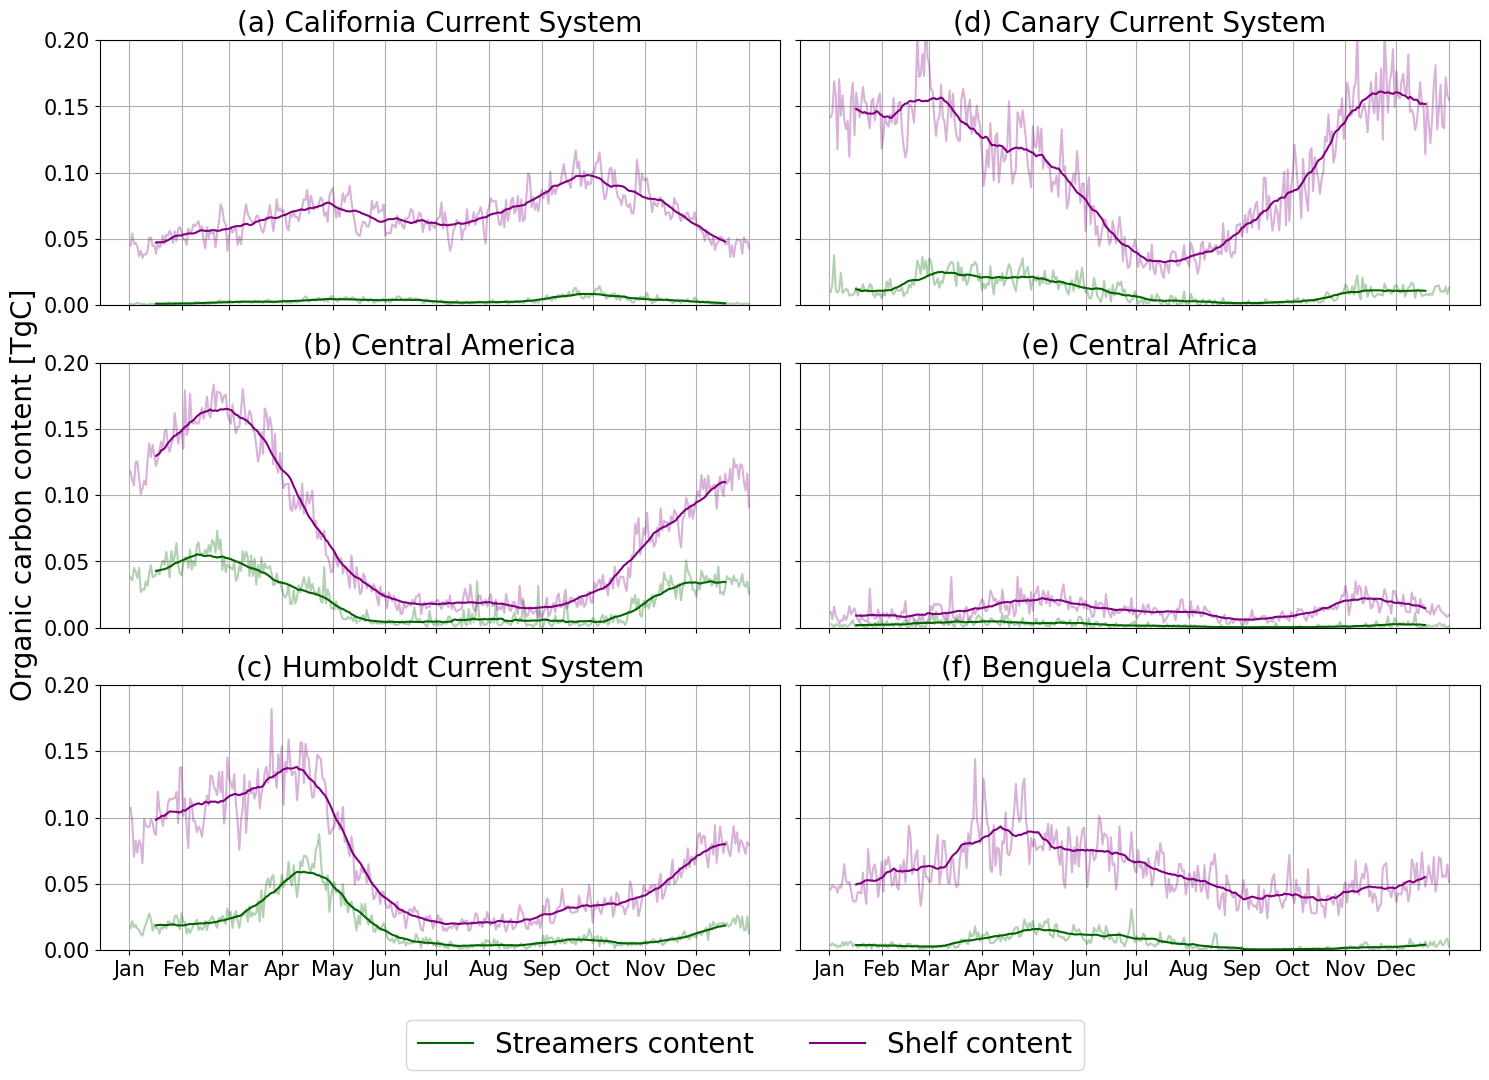

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = [15,10], sharey=True, sharex=True)

path = 'sensitivity_test_years/pacific/10years/outputs/'
ax[:,0] = plot_seasonality(ax[:,0], path)
for a, t in zip(ax[:,0], ['(a) ', '(b) ', '(c) ']):
    if a == ax[0,0] or a == ax[2,0]:
        a.set_ylabel('')
    a.set_title(t + a.get_title(), fontsize = 20)

path = 'sensitivity_test_years/atlantic/10years'
ax[:,1] = plot_seasonality(ax[:,1], path)

for a, t in zip(ax[:,1], ['(d) ', '(e) ', '(f) ']):
    a.set_ylabel('')
    a.set_title(t + a.get_title(), fontsize = 20)


handles = [Line2D([0], [0], linestyle=style, label = label, color = color) for style, label, color in zip(['solid', 'solid'], ['Streamers content', 'Shelf content'], ['darkgreen', 'purple'])] 
fig.legend(handles = handles, bbox_to_anchor=(0.5, -0.05), loc = 'center', ncol=2, prop = {'size' : 20})
fig.tight_layout()
#fig.suptitle('Seasonality of carbon content', fontsize = 25, y = 1.07)
plt.savefig('images/export_seasonality.jpg', bbox_inches = 'tight')